In [15]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LogNorm

# use the CAMB cosmology that generated the matter power spectra
import camb
from cosmology import Cosmology

# almost all GLASS functionality is available from the `glass` namespace
import glass
import glass.ext.camb

import sys
sys.path.append('../code')
import plotter

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
# creating a numpy random number generator for sampling
rng = np.random.default_rng(seed=42)

# cosmology for the simulation
# planck18, via: https://docs.astropy.org/en/stable/api/astropy.cosmology.realizations.Planck18.html
h = 0.6766
Oc = 0.30966
Ob = 0.04897

# basic parameters of the simulation
nside = lmax = 128

# set up CAMB parameters for matter angular power spectrum
pars = camb.set_params(
    H0=100 * h,
    omch2=Oc * h**2,
    ombh2=Ob * h**2,
    NonLinear=camb.model.NonLinear_both,
)

# get the cosmology from CAMB
cosmo = Cosmology.from_camb(pars)

In [3]:
z_min = 0.0
z_max = 1.0

# shells of 200 Mpc in comoving distance spacing
zb = glass.distance_grid(cosmo, z_min, z_max, dx=200.0)

# linear radial window functions
shells = glass.linear_windows(zb)

# compute the angular matter power spectra of the shells with CAMB
cls = glass.ext.camb.matter_cls(pars, lmax, shells)

In [4]:
# set up lognormal matter fields for simulation
fields = glass.lognormal_fields(shells)

# apply discretisation to the full set of spectra:
# - HEALPix pixel window function (`nside=nside`)
# - maximum angular mode number (`lmax=lmax`)
# - number of correlated shells (`ncorr=3`)
cls = glass.discretized_cls(cls, nside=nside, lmax=lmax, ncorr=3)

# compute Gaussian spectra for lognormal fields from discretised spectra
gls = glass.solve_gaussian_spectra(fields, cls)

# generator for lognormal matter fields
matter = glass.generate(fields, gls, nside, ncorr=3, rng=rng)

### Galaxies

In [ ]:
# constant galaxy density distribution
nbar_gal = 0.01 
z_gal = np.linspace(z_min, z_max, 100)
dndz_gal = np.full_like(z_gal, nbar_gal)
print(z_gal.shape)
print(dndz_gal.shape)
print(len(shells))

# distribute the dN/dz over the linear window functions
# ngal_arr is in shells
ngal_arr = glass.partition(z_gal, dndz_gal, shells)

# added, via other tutorial: https://glass.readthedocs.io/stable/examples/2-advanced/stage_4_galaxies.html
bias_gal = 1.5

(100,)
(100,)
16


### AGN

In [ ]:
# constant agn density distribution
nbar_agn = 0.0001  # number density of AGN
z_agn = np.linspace(z_min, z_max, 100)
dndz_agn = np.full_like(z_agn, nbar_agn)

# distribute the dN/dz over the linear window functions
nagn_arr = glass.partition(z_agn, dndz_agn, shells)

# added, via other tutorial: https://glass.readthedocs.io/stable/examples/2-advanced/stage_4_galaxies.html
bias_agn = 2.5

In [ ]:
# Function to compute 3D Cartesian positions from lon, lat, and redshift arrays
def compute_3d_positions(lon, lat, redshift):
    x = redshift * np.cos(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))
    y = redshift * np.sin(np.deg2rad(lon)) * np.cos(np.deg2rad(lat))
    z = redshift * np.sin(np.deg2rad(lat))
    return np.stack([x, y, z], axis=-1)

In [26]:

# Define tracers as a dictionary
tracers = {
    'galaxies': {'bias': bias_gal, 'N': ngal_arr},
    'agn': {'bias': bias_agn, 'N': nagn_arr},
}

positions_3d = {name: [] for name in tracers}
positions_sky = {name: [] for name in tracers}  # Will hold (ra, dec, z)

matter = list(matter)  # Convert generator to a list for multiple iterations
for tracer_name, tracer_dict in tracers.items():
    print(f"Processing tracer: {tracer_name}")
    for i, delta_i in enumerate(matter):
        # Get all positions for this shell and tracer
        positions_from_delta = glass.positions_from_delta(
            tracer_dict['N'][i],
            delta_i,
            bias=tracer_dict['bias'],
            rng=rng,
        )
        for lon, lat, count in positions_from_delta:
            # Sample redshifts for these sources
            z = glass.redshifts(count, shells[i], rng=rng)
            # Store sky positions (ra, dec, z)
            sky_pos = np.stack([lon, lat, z], axis=-1)
            positions_sky[tracer_name].append(sky_pos)
            # Store 3D positions
            pos = compute_3d_positions(lon, lat, z, bias=tracer_dict['bias'])
            positions_3d[tracer_name].append(pos)

# Concatenate all positions for each tracer into a single array
for name in positions_3d:
    positions_3d[name] = np.concatenate(positions_3d[name], axis=0)
for name in positions_sky:
    positions_sky[name] = np.concatenate(positions_sky[name], axis=0)
    positions_sky[name][:, 0] = positions_sky[name][:, 0] % 360

# positions_3d['galaxies'] and positions_3d['agn'] are arrays of shape (N, 3) for (x, y, z)
# positions_sky['galaxies'] and positions_sky['agn'] are arrays of shape (N, 3) for (ra, dec, z)

Processing tracer: galaxies
Processing tracer: agn


In [27]:
print(f"Galaxies positions shape: {positions_sky['galaxies'].shape}")
print(f"AGN positions shape: {positions_sky['agn'].shape}")

Galaxies positions shape: (1486655, 3)
AGN positions shape: (14980, 3)


In [28]:
np.min(positions_sky['galaxies'], axis=0), np.max(positions_sky['galaxies'], axis=0)

(array([ 1.13527834e-05, -8.99671447e+01,  8.56780726e-07]),
 array([359.99990647,  89.95909179,   1.04113288]))

In [29]:
np.min(positions_sky['agn'], axis=0), np.max(positions_sky['agn'], axis=0)

(array([ 3.63102283e-02, -8.93435169e+01,  5.17967697e-04]),
 array([359.99430033,  88.75815565,   1.03927277]))

(<Figure size 1000x600 with 1 Axes>, <MollweideAxes: >)

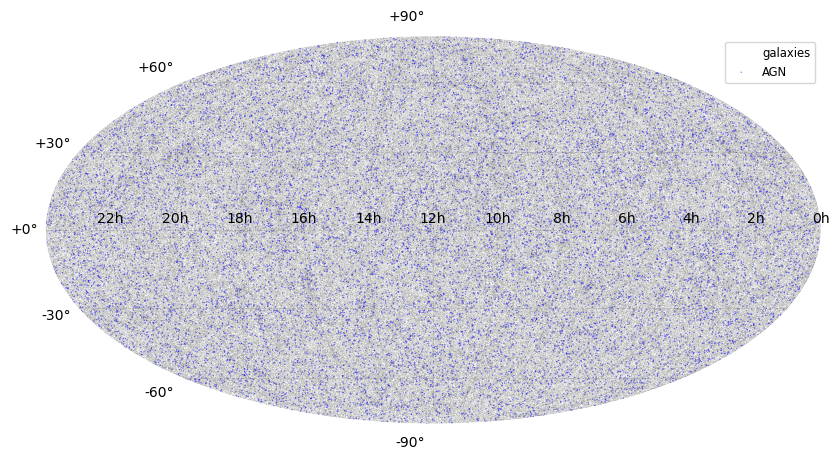

In [31]:
# Prepare RA and Dec arrays for plotting from positions_sky
ra_arr = [positions_sky['galaxies'][:, 0], positions_sky['agn'][:, 0]]
dec_arr = [positions_sky['galaxies'][:, 1], positions_sky['agn'][:, 1]]
c_arr = ['k', 'b']
alpha_arr = [0.1, 0.5]

s_arr = [0.2, 1]
label_arr = ['galaxies', 'AGN']

plotter.create_skyplot(ra_arr, dec_arr, alpha_arr=alpha_arr, s_arr=s_arr, c_arr=c_arr, label_arr=label_arr)

In [ ]:
## Choose sources to host GWs
## TODO deal with completeness!
f_agn = 0.2
f_agn_comp = 1
f_gal_phys = 1 - f_agn_phys
f_gal_comp = 1

In [ ]:
n_gw = 100
i_gw_agn = np.random.randint(0, len(ra_agn.compute()), int(f_agn_phys*n_gw))
i_gw_gal = np.random.randint(0, len(ra_gal.compute()), int(f_gal_phys*n_gw))

(<Figure size 1000x600 with 1 Axes>, <MollweideAxes: >)

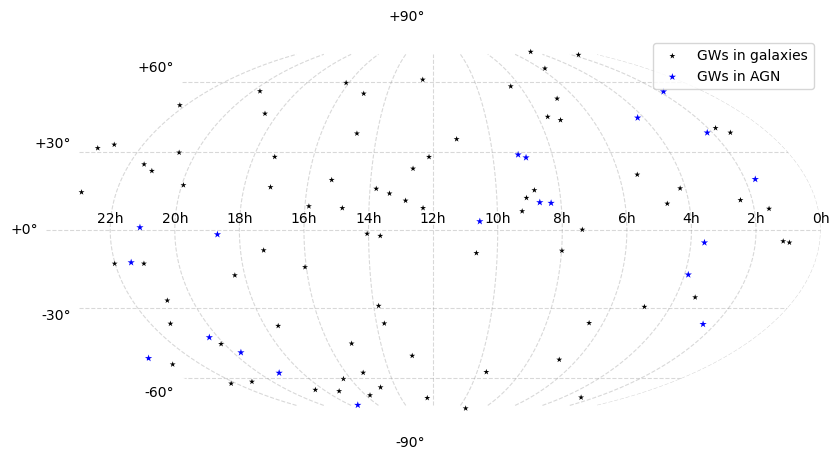

In [ ]:
ra_gal_gw = ra_gal

ra_arr = [ra_gal.compute()[i_gw_gal], ra_agn.compute()[i_gw_agn]]
dec_arr = [dec_gal.compute()[i_gw_gal], dec_agn.compute()[i_gw_agn]]
c_arr = ['k', 'b']
alpha_arr = [1, 1]
s_arr = [20, 30]
label_arr = ['GWs in galaxies', 'GWs in AGN']
marker_arr = ['*', '*']

plotter.create_skyplot(ra_arr, dec_arr, alpha_arr=alpha_arr, s_arr=s_arr, 
                       c_arr=c_arr, label_arr=label_arr, marker_arr=marker_arr)